# <center> SS60 중간발표</center>

# <center> 프로세스 </center>
# 0. 환경설정
# 1. 모델의 성능
# 2. 변수설명
# 3. 전처리 및 EDA
# 4. lightgbm을 사용한 분류
# 5. kaggle에 제출
# 6. 한계점 및 보완방향

# <center>0.환경설정</center>

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import lightgbm
import warnings
import numpy as np
import pandas as pd
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# <center> 1. 모델의 성능</center>

## Accuracy

In [160]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
                           for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 76.37%


## Classification_report

In [161]:
# 성능을 저장해놓고 보여주기 위한 코드입니다. 코드를 실행할 땐 전처리 과정을 모두 실행해줘야만 코드가 돌아갑니다.
print(classification_report(y_labeled, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       931
           1       0.78      0.66      0.71        87
           2       0.84      0.87      0.85      1167
           3       0.83      0.87      0.85       309
           4       0.78      0.79      0.79      1494
           5       0.88      0.90      0.89      3017
           6       0.78      0.84      0.81      2307
           7       0.58      0.35      0.44        62
           8       0.00      0.00      0.00         2
           9       0.65      0.55      0.60       237
          10       0.54      0.50      0.52       131
          11       0.72      0.64      0.68        80
          12       0.77      0.62      0.69       173
          13       0.71      0.69      0.70       158
          14       0.60      0.64      0.62       207
          15       0.73      0.56      0.63        43
          16       0.69      0.69      0.69       652
          17       0.74    

# <center>2. 변수설명</center>

# 2-1. `TripType`  [target]
- 이번 분석에서의 Target값

- 고객의 구매 활동을 나타내는 카테고리컬 식별값입니다. 
- 다른 변수들을 분석해 38가지 중에 하나로 분류해야 합니다. 
- TripType '999' 는 총 구매한 아이템의 수가 음수, 즉 최종 구매 활동이 반환 인 구매자를 의미합니다.

In [3]:
print(train.TripType.unique())
print("{}가지 ID가 있습니다.".format(len(train.TripType.unique())))

[999  30  26   8  35  41  21   6  42   7   9  39  25  38  15  36  20  37
  32  40   5   3   4  24  33  43  31  27  34  18  29  44  19  23  22  28
  14  12]
38가지 ID가 있습니다.


# 2.2 `VisitNumber`
- 단일 고객의 단일 구매 활동을 나타내는 값
- 95674가지 값을 가집니다.

In [4]:
len(train.VisitNumber.unique())

95674

In [5]:
print(train.VisitNumber.unique())

[     5      7      8 ... 191345 191346 191347]


# 2.3 `Weekday` 
- 거래가 일어난 요일을 나타냅니다.

In [7]:
print(train.Weekday.unique())

['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']


# 2.4 `Upc`
- Universal Product Code. 구매한 제품의 고유값
- 97715개 상품이 팔렸습니다.

In [8]:
len(train.Upc.unique())

97715

# 2.5 `ScanCount`
- 해당 상품을 한번에 몇 개 샀는지를 나타냅니다.
- 반품했을 경우 음수값으로 표시합니다.

In [9]:
print(train.ScanCount.unique())
print(train.ScanCount.describe())

[ -1   1   2   3   5   6   4  14  -2   9   7  10   8  -3  -5  11  16  -4
  13  15  30  -6  12  20 -12  19  46  23  -7  22  25  24  31  -9  51  17
  18  71 -10]
count    647054.000000
mean          1.108878
std           0.700776
min         -12.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          71.000000
Name: ScanCount, dtype: float64


# 2.6 `DepartmentDescription` 
- 상품 대분류
- 이 기준에 따르면 상품들은 68가지로 분류됩니다.

In [3]:
len(train["DepartmentDescription"].unique().tolist())
train = train.replace('MENSWEAR', 'MENS WEAR')
test = test.replace('MENSWEAR', 'MENS WEAR')

In [4]:
print(len(train.DepartmentDescription.unique()))
print(train.DepartmentDescription.unique())

68
['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS'
 'CELEBRATION' 'HARDWARE' 'BEAUTY' 'AUTOMOTIVE' 'BOOKS AND MAGAZINES'
 'SEAFOOD' 'OFFICE SUPPLIES' 'LAWN AND GARDEN' 'SHEER HOSIERY' 'WIRELESS'
 'BEDDING' 'BATH AND SHOWER' 'HORTICULTURE AND ACCESS' 'HOME DECOR' 'TOYS'
 'INFANT APPAREL' 'LADIES SOCKS' 'PLUS AND MATERNITY' 'ELECTRONICS'
 'GIRLS WEAR, 4-6X  AND 7-14' 'BRAS & SHAPEWEAR' 'LIQUOR,WINE,BEER'
 'SLEEPWEAR/FOUNDATIONS' 'CAMERAS AND SUPPLIES' 'SPORTING GOODS'
 'PLAYERS AND ELECTRONICS' 'PHARMACY RX' 'OPTICAL - FRA

In [12]:
train[train.DepartmentDescription == 'SHOES'].count()

TripType                 6099
VisitNumber              6099
Weekday                  6099
Upc                      6099
ScanCount                6099
DepartmentDescription    6099
FinelineNumber           6099
dtype: int64

In [13]:
train[train.DepartmentDescription == 'FINANCIAL SERVICES'].count()

TripType                 10723
VisitNumber              10723
Weekday                  10723
Upc                      10723
ScanCount                10723
DepartmentDescription    10723
FinelineNumber           10723
dtype: int64

# 2.7 `FinelineNumber` 
- 월마트가 자체적으로 사용하는 세분화된 상품 분류 코드
- 이 기준에 따르면 상품들은 5196가지로 분류됩니다.

In [14]:
print(len(train.FinelineNumber.unique()))
print(train.FinelineNumber.unique())

5196
[1000. 8931. 4504. ... 8257. 4314. 7130.]


# <center>3.전처리 및 EDA</center>

# 3-1. `TripType` 별 카운트

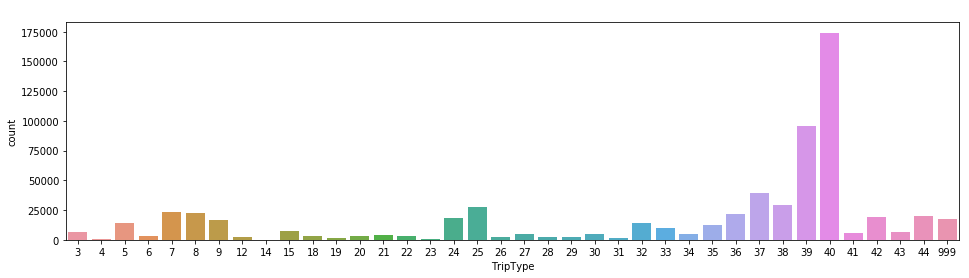

In [27]:
plt.figure(figsize=(16, 4))
sns.countplot(x="TripType", data=train)
plt.title(" ")
plt.show()

# 3-2. `DepartmentDescription`, `FinelineNumber`의 관계

`FinelineNumber`이 nan일 경우, `Upc`가 함께 nan이며 `DepartmentDescription`는 nan 혹은 `PHARMACY RX`입니다.

In [15]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

# 3-3.  MENSWEAR 와 MENS WEAR는 같은 값이므로 MENSWEAR로 합쳐준다.

In [61]:
# len(train["DepartmentDescription"].unique().tolist())

68

In [62]:
# train = train.replace('MENSWEAR', 'MENS WEAR')
# test = test.replace('MENSWEAR', 'MENS WEAR')

# 3-4. pos_sum, neg_sum, return과 관련된 컬럼을 만든다.

In [5]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [6]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [7]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [27]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,Pos_Sum,Neg_Sum
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,1.0,0,-1
1,30,7,Friday,60538815980,1,SHOES,8931.0,0.0,1,0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,0.0,1,0
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,0.0,2,0
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,0.0,2,0


# 3-5. UPC와 관련한 특징을 만든다.

In [8]:
def float_to_str(obj):
    while obj != "nan":
        obj = str(obj).split(".")[0]
        return obj


train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train_upc_fine = train[["VisitNumber", "Upc"]]
test_upc_fine = test[["VisitNumber", "Upc"]]

train_upc_fine["len_of_UPC"] = train_upc_fine["Upc"].apply(lambda x: len(x))
test_upc_fine["len_of_UPC"] = test_upc_fine["Upc"].apply(lambda x: len(x))

train_UPC = pd.get_dummies(train_upc_fine["len_of_UPC"])
train_UPC = pd.concat([train[["VisitNumber"]], train_UPC], axis=1)
train_UPC = train_UPC.groupby("VisitNumber", as_index=False).sum()

test_UPC = pd.get_dummies(test_upc_fine["len_of_UPC"])
test_UPC = pd.concat([test[["VisitNumber"]], test_UPC], axis=1)
test_UPC = test_UPC.groupby("VisitNumber", as_index=False).sum()

In [29]:
train_UPC.tail()

,VisitNumber,3,4,5,7,8,9,10,11,12
95669,191343,0,0,0,0,0,0,2,5,0
95670,191344,0,0,0,0,0,0,3,2,0
95671,191345,0,0,0,0,0,0,11,2,0
95672,191346,0,1,0,0,0,0,15,1,0
95673,191347,0,0,0,0,0,0,2,0,0


# 3-6. Fineline과 관련한 특징을 만든다.

In [24]:
train_FL = pd.get_dummies(train["FinelineNumber"])
test_FL = pd.get_dummies(test["FinelineNumber"])

train_FL = pd.concat([train[["VisitNumber"]], train_FL], axis=1)
test_FL = pd.concat([test[["VisitNumber"]], test_FL], axis=1)

In [28]:
train_FL = train_FL.groupby("VisitNumber", as_index=False).sum()  # sum을 함
test_FL = test_FL.groupby("VisitNumber", as_index=False).sum()
train_FL.tail()

,VisitNumber,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,9964.0,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191345,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3-7. Department Description과 관련한 특징을 만든다.

In [29]:
# Departmentdescription으로 더미변수 생성. 비짓 넘버와 결합한것이 train_dd
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()  # sum을 함
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()
train_dd.tail()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,191345,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
traincolumn = list(train["DepartmentDescription"].unique())
WEARls = [x for x in traincolumn if 'WEAR' in str(x) or 'SOCKS' in str(x) or 'SHOES' in str(x)
          or 'MATERNITY' in str(x)]
FOODls = [x for x in traincolumn if 'FOOD' in str(x) or 'MEAT' in str(x) or 'DAIRY' in str(x) or 'GROCERY' in str(x)
          or 'PRODUCE' in str(x) or "BREAD" in str(x) or 'BAKERY' in str(x) or 'WINE' in str(x) or "DELI" in str(x)
          or 'COOKIE' in str(x) or 'COOK' in str(x)]
ACCls = [x for x in traincolumn if 'SUNGLASS' in str(x) or 'OPTICAL' in str(x)]
ELECls = [x for x in traincolumn if 'ELECTRONICS' in str(x) or 'CAMERAS' in str(x) or 'MEDIA' in str(x)
          or 'WIRELESS' in str(x) or 'HARDWARE' in str(x)]
COSls = [x for x in traincolumn if 'PERSONAL' in str(x) or 'BEAUTY' in str(x) or 'PHARMACY' in str(x)
         or 'BATH' in str(x)]
HOUSEls = [x for x in traincolumn if 'PAPER' in str(x) or 'HOME' in str(x) or "BEDDING" in str(x)
           or 'HOUSE' in str(x) or 'CELE' in str(x) or 'OFFICE' in str(x)]
GARDENls = [x for x in traincolumn if 'GARDEN' in str(x) or 'HORTI' in str(x)]
INFANls = [x for x in traincolumn if 'INFANT' in str(x)]
WEARls

['SHOES',
 'BOYS WEAR',
 'MENS WEAR',
 'LADIESWEAR',
 'LADIES SOCKS',
 'PLUS AND MATERNITY',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'BRAS & SHAPEWEAR',
 'SLEEPWEAR/FOUNDATIONS',
 'SWIMWEAR/OUTERWEAR']

In [32]:
traindf = train.copy()
testdf = test.copy()
traindf.loc[traindf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
traindf.loc[traindf['DepartmentDescription'].isin(
    GARDENls), "DD_big"] = "GARDEN"
traindf.loc[traindf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
traindf.loc[traindf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
traindf.loc[traindf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
traindf.loc[traindf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
traindf.loc[traindf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
traindf.loc[traindf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

testdf.loc[testdf['DepartmentDescription'].isin(INFANls), "DD_big"] = "INFAN"
testdf.loc[testdf['DepartmentDescription'].isin(GARDENls), "DD_big"] = "GARDEN"
testdf.loc[testdf['DepartmentDescription'].isin(HOUSEls), "DD_big"] = "HOUSE"
testdf.loc[testdf['DepartmentDescription'].isin(COSls), "DD_big"] = "COS"
testdf.loc[testdf['DepartmentDescription'].isin(ELECls), "DD_big"] = "ELEC"
testdf.loc[testdf['DepartmentDescription'].isin(ACCls), "DD_big"] = "ACC"
testdf.loc[testdf['DepartmentDescription'].isin(FOODls), "DD_big"] = "FOOD"
testdf.loc[testdf['DepartmentDescription'].isin(WEARls), "DD_big"] = "WEAR"

In [33]:
train_dd_big = pd.get_dummies(traindf["DD_big"])
test_dd_big = pd.get_dummies(testdf["DD_big"])

train_dd_big = pd.concat([traindf[["VisitNumber"]], train_dd_big], axis=1)
test_dd_big = pd.concat([testdf[["VisitNumber"]], test_dd_big], axis=1)

train_dd_big = train_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big = test_dd_big.groupby("VisitNumber", as_index=False).sum()
test_dd_big.tail()

,VisitNumber,ACC,COS,ELEC,FOOD,GARDEN,HOUSE,INFAN,WEAR
95669,191338,0,0,0,3,0,4,0,0
95670,191339,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,4,6,0
95673,191348,0,2,0,0,0,0,0,5


# 3-8. 요일과 관련된 더미변수를 만든다.

- TripType 14와 같이 요일이 큰 영향을 주는 경우가 있다.

In [20]:
weekday = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}
train_weekday = train[["Weekday", "VisitNumber", "TripType"]]
train_weekday["Weekday"] = train_weekday["Weekday"].apply(lambda x: weekday[x])

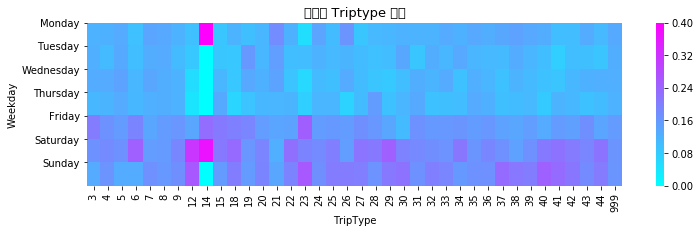

In [21]:
plt.figure(figsize=(12, 3))
sns.heatmap(data=pd.crosstab(train_weekday["Weekday"],
                             train_weekday["TripType"],
                             values=train_weekday["VisitNumber"],
                             aggfunc='count',
                             normalize="columns"), cmap="cool")
plt.yticks(range(0, 7), list(weekday.keys()), rotation="horizontal")
plt.title("요일별 Triptype 분포", fontsize=13)
plt.show()

In [34]:
train_weekday = pd.get_dummies(train["Weekday"])
test_weekday = pd.get_dummies(testdf["Weekday"])

train_weekday = pd.concat([train[["VisitNumber"]], train_weekday], axis=1)
test_weekday = pd.concat([test[["VisitNumber"]], test_weekday], axis=1)

train_weekday = train_weekday.groupby("VisitNumber", as_index=False).sum()
test_weekday = test_dd_big.groupby("VisitNumber", as_index=False).sum()
train_weekday.tail()

,VisitNumber,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
95669,191343,0,0,0,7,0,0,0
95670,191344,0,0,0,5,0,0,0
95671,191345,0,0,0,13,0,0,0
95672,191346,0,0,0,17,0,0,0
95673,191347,0,0,0,2,0,0,0


# 3-7. 만들어준 데이터 프레임을 합쳐준다.

In [42]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train = train_by_sum.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_UPC, on=["VisitNumber"])
train = train.merge(train_dd_big, on=["VisitNumber"])
train = train.merge(train_FL, on=["VisitNumber"])
train = train.merge(train_weekday, on=["VisitNumber"])


test = test_by_sum.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_UPC, on=["VisitNumber"])
test = test.merge(test_dd_big, on=["VisitNumber"])
test = test.merge(test_FL, on=["VisitNumber"])
test = test.merge(test_weekday, on=["VisitNumber"])

In [43]:
train.tail()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,9991.0,9997.0,9998.0,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
95669,191343,9,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0
95670,191344,5,5,0,0,0,0,0,0,4,...,0,0,0,0,0,0,5,0,0,0
95671,191345,17,17,0,0,0,0,0,0,1,...,0,0,0,0,0,0,13,0,0,0
95672,191346,17,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17,0,0,0
95673,191347,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [44]:
y = traindf[["TripType", 'VisitNumber']]
y.drop_duplicates(inplace=True)
y = y["TripType"]

# 3-8. test와 train 데이터의 shape을 맞춰준다.

In [45]:
not_in_train = [i for i in test.columns if i not in train.columns]

not_in_test = [i for i in train.columns if i not in test.columns]

In [46]:
total_train = train.drop(columns=not_in_test)

In [47]:
total_test = test.drop(columns=not_in_train)

# <center>4. lightgbm을 사용한 분류</center>

In [48]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    total_train, y_labeled, random_state=0)

In [50]:
dtrain = lightgbm.Dataset(X_train, label=y_train)

In [51]:
dtest = lightgbm.Dataset(X_test, label=y_test)

In [52]:
num_boost_round = 2000
learning_rate = 0.02

params = {'objective': 'multiclass',
          'boosting_type': 'gbdt',
          'max_depth': -1,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class': 38,
          'learning_rate': learning_rate,
          }

In [53]:
lightgbm_model = lightgbm.train(params=params,
                                train_set=dtrain,
                                valid_sets=[dtrain, dtest],
                                num_boost_round=num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 2.91971	valid_1's multi_logloss: 2.92784
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 2.81473	valid_1's multi_logloss: 2.82852
[3]	training's multi_logloss: 2.72692	valid_1's multi_logloss: 2.74481
[4]	training's multi_logloss: 2.65039	valid_1's multi_logloss: 2.67181
[5]	training's multi_logloss: 2.58189	valid_1's multi_logloss: 2.60604
[6]	training's multi_logloss: 2.51973	valid_1's multi_logloss: 2.54633
[7]	training's multi_logloss: 2.46239	valid_1's multi_logloss: 2.49152
[8]	training's multi_logloss: 2.40931	valid_1's multi_logloss: 2.44087
[9]	training's multi_logloss: 2.35992	valid_1's multi_logloss: 2.39349
[10]	training's multi_logloss: 2.31377	valid_1's multi_logloss: 2.34924
[11]	training's multi_logloss: 2.27018	valid_1's multi_logloss: 2.30735
[12]	training's multi_logloss: 2.22907	valid_1's multi_logloss: 2.26789
[13]	training's multi_logloss: 2.19011	valid_1's multi_logloss: 2.2306
[14]	trainin

[114]	training's multi_logloss: 0.945192	valid_1's multi_logloss: 1.06121
[115]	training's multi_logloss: 0.940902	valid_1's multi_logloss: 1.05743
[116]	training's multi_logloss: 0.93676	valid_1's multi_logloss: 1.05379
[117]	training's multi_logloss: 0.932598	valid_1's multi_logloss: 1.05017
[118]	training's multi_logloss: 0.928516	valid_1's multi_logloss: 1.04658
[119]	training's multi_logloss: 0.924507	valid_1's multi_logloss: 1.04309
[120]	training's multi_logloss: 0.920524	valid_1's multi_logloss: 1.03958
[121]	training's multi_logloss: 0.916617	valid_1's multi_logloss: 1.03615
[122]	training's multi_logloss: 0.912745	valid_1's multi_logloss: 1.03276
[123]	training's multi_logloss: 0.908914	valid_1's multi_logloss: 1.02941
[124]	training's multi_logloss: 0.905162	valid_1's multi_logloss: 1.02616
[125]	training's multi_logloss: 0.901451	valid_1's multi_logloss: 1.02295
[126]	training's multi_logloss: 0.89779	valid_1's multi_logloss: 1.01974
[127]	training's multi_logloss: 0.894141

[224]	training's multi_logloss: 0.676167	valid_1's multi_logloss: 0.840908
[225]	training's multi_logloss: 0.674717	valid_1's multi_logloss: 0.839904
[226]	training's multi_logloss: 0.67331	valid_1's multi_logloss: 0.838938
[227]	training's multi_logloss: 0.671888	valid_1's multi_logloss: 0.837927
[228]	training's multi_logloss: 0.670504	valid_1's multi_logloss: 0.837002
[229]	training's multi_logloss: 0.669103	valid_1's multi_logloss: 0.836005
[230]	training's multi_logloss: 0.667754	valid_1's multi_logloss: 0.835078
[231]	training's multi_logloss: 0.666333	valid_1's multi_logloss: 0.834083
[232]	training's multi_logloss: 0.664973	valid_1's multi_logloss: 0.833131
[233]	training's multi_logloss: 0.663622	valid_1's multi_logloss: 0.832211
[234]	training's multi_logloss: 0.662255	valid_1's multi_logloss: 0.83128
[235]	training's multi_logloss: 0.66086	valid_1's multi_logloss: 0.830307
[236]	training's multi_logloss: 0.65952	valid_1's multi_logloss: 0.829349
[237]	training's multi_loglos

[334]	training's multi_logloss: 0.557332	valid_1's multi_logloss: 0.767363
[335]	training's multi_logloss: 0.556525	valid_1's multi_logloss: 0.766934
[336]	training's multi_logloss: 0.555679	valid_1's multi_logloss: 0.766502
[337]	training's multi_logloss: 0.554852	valid_1's multi_logloss: 0.766055
[338]	training's multi_logloss: 0.554025	valid_1's multi_logloss: 0.765625
[339]	training's multi_logloss: 0.553222	valid_1's multi_logloss: 0.765217
[340]	training's multi_logloss: 0.5524	valid_1's multi_logloss: 0.764755
[341]	training's multi_logloss: 0.551607	valid_1's multi_logloss: 0.764355
[342]	training's multi_logloss: 0.550793	valid_1's multi_logloss: 0.763947
[343]	training's multi_logloss: 0.549966	valid_1's multi_logloss: 0.763554
[344]	training's multi_logloss: 0.549127	valid_1's multi_logloss: 0.76312
[345]	training's multi_logloss: 0.548329	valid_1's multi_logloss: 0.762678
[346]	training's multi_logloss: 0.547536	valid_1's multi_logloss: 0.762291
[347]	training's multi_loglo

[444]	training's multi_logloss: 0.482304	valid_1's multi_logloss: 0.732324
[445]	training's multi_logloss: 0.481745	valid_1's multi_logloss: 0.732085
[446]	training's multi_logloss: 0.48117	valid_1's multi_logloss: 0.731844
[447]	training's multi_logloss: 0.480624	valid_1's multi_logloss: 0.731622
[448]	training's multi_logloss: 0.480072	valid_1's multi_logloss: 0.731441
[449]	training's multi_logloss: 0.479508	valid_1's multi_logloss: 0.731213
[450]	training's multi_logloss: 0.478961	valid_1's multi_logloss: 0.731014
[451]	training's multi_logloss: 0.47839	valid_1's multi_logloss: 0.730759
[452]	training's multi_logloss: 0.477839	valid_1's multi_logloss: 0.730527
[453]	training's multi_logloss: 0.477275	valid_1's multi_logloss: 0.730324
[454]	training's multi_logloss: 0.476738	valid_1's multi_logloss: 0.730093
[455]	training's multi_logloss: 0.476187	valid_1's multi_logloss: 0.729906
[456]	training's multi_logloss: 0.47566	valid_1's multi_logloss: 0.729692
[457]	training's multi_loglo

[554]	training's multi_logloss: 0.427721	valid_1's multi_logloss: 0.71252
[555]	training's multi_logloss: 0.427282	valid_1's multi_logloss: 0.712375
[556]	training's multi_logloss: 0.426855	valid_1's multi_logloss: 0.71221
[557]	training's multi_logloss: 0.426411	valid_1's multi_logloss: 0.712079
[558]	training's multi_logloss: 0.42598	valid_1's multi_logloss: 0.711948
[559]	training's multi_logloss: 0.425555	valid_1's multi_logloss: 0.711784
[560]	training's multi_logloss: 0.425127	valid_1's multi_logloss: 0.711672
[561]	training's multi_logloss: 0.424663	valid_1's multi_logloss: 0.711507
[562]	training's multi_logloss: 0.424241	valid_1's multi_logloss: 0.711363
[563]	training's multi_logloss: 0.423796	valid_1's multi_logloss: 0.711221
[564]	training's multi_logloss: 0.423377	valid_1's multi_logloss: 0.711124
[565]	training's multi_logloss: 0.422933	valid_1's multi_logloss: 0.710981
[566]	training's multi_logloss: 0.422493	valid_1's multi_logloss: 0.710814
[567]	training's multi_loglo

[664]	training's multi_logloss: 0.384966	valid_1's multi_logloss: 0.700424
[665]	training's multi_logloss: 0.384629	valid_1's multi_logloss: 0.700337
[666]	training's multi_logloss: 0.384282	valid_1's multi_logloss: 0.700251
[667]	training's multi_logloss: 0.383936	valid_1's multi_logloss: 0.70016
[668]	training's multi_logloss: 0.383571	valid_1's multi_logloss: 0.700053
[669]	training's multi_logloss: 0.383227	valid_1's multi_logloss: 0.699966
[670]	training's multi_logloss: 0.382879	valid_1's multi_logloss: 0.699888
[671]	training's multi_logloss: 0.382525	valid_1's multi_logloss: 0.699821
[672]	training's multi_logloss: 0.382182	valid_1's multi_logloss: 0.699748
[673]	training's multi_logloss: 0.381824	valid_1's multi_logloss: 0.69966
[674]	training's multi_logloss: 0.381492	valid_1's multi_logloss: 0.699556
[675]	training's multi_logloss: 0.381132	valid_1's multi_logloss: 0.69946
[676]	training's multi_logloss: 0.380792	valid_1's multi_logloss: 0.699411
[677]	training's multi_loglo

[774]	training's multi_logloss: 0.350211	valid_1's multi_logloss: 0.692985
[775]	training's multi_logloss: 0.349933	valid_1's multi_logloss: 0.692957
[776]	training's multi_logloss: 0.349649	valid_1's multi_logloss: 0.692897
[777]	training's multi_logloss: 0.34937	valid_1's multi_logloss: 0.692842
[778]	training's multi_logloss: 0.34908	valid_1's multi_logloss: 0.692794
[779]	training's multi_logloss: 0.348804	valid_1's multi_logloss: 0.692741
[780]	training's multi_logloss: 0.348512	valid_1's multi_logloss: 0.692702
[781]	training's multi_logloss: 0.348236	valid_1's multi_logloss: 0.692644
[782]	training's multi_logloss: 0.34795	valid_1's multi_logloss: 0.692579
[783]	training's multi_logloss: 0.347678	valid_1's multi_logloss: 0.692536
[784]	training's multi_logloss: 0.347401	valid_1's multi_logloss: 0.692496
[785]	training's multi_logloss: 0.347115	valid_1's multi_logloss: 0.692447
[786]	training's multi_logloss: 0.346831	valid_1's multi_logloss: 0.692407
[787]	training's multi_loglo

[884]	training's multi_logloss: 0.32113	valid_1's multi_logloss: 0.688648
[885]	training's multi_logloss: 0.320887	valid_1's multi_logloss: 0.688635
[886]	training's multi_logloss: 0.32064	valid_1's multi_logloss: 0.68861
[887]	training's multi_logloss: 0.320398	valid_1's multi_logloss: 0.688587
[888]	training's multi_logloss: 0.320153	valid_1's multi_logloss: 0.68855
[889]	training's multi_logloss: 0.319901	valid_1's multi_logloss: 0.688511
[890]	training's multi_logloss: 0.319641	valid_1's multi_logloss: 0.688479
[891]	training's multi_logloss: 0.319392	valid_1's multi_logloss: 0.688453
[892]	training's multi_logloss: 0.319149	valid_1's multi_logloss: 0.68841
[893]	training's multi_logloss: 0.318891	valid_1's multi_logloss: 0.688331
[894]	training's multi_logloss: 0.318637	valid_1's multi_logloss: 0.688296
[895]	training's multi_logloss: 0.318393	valid_1's multi_logloss: 0.688242
[896]	training's multi_logloss: 0.318151	valid_1's multi_logloss: 0.688209
[897]	training's multi_logloss

[994]	training's multi_logloss: 0.295948	valid_1's multi_logloss: 0.686165
[995]	training's multi_logloss: 0.295732	valid_1's multi_logloss: 0.686153
[996]	training's multi_logloss: 0.295518	valid_1's multi_logloss: 0.686141
[997]	training's multi_logloss: 0.29531	valid_1's multi_logloss: 0.686118
[998]	training's multi_logloss: 0.2951	valid_1's multi_logloss: 0.686127
[999]	training's multi_logloss: 0.294892	valid_1's multi_logloss: 0.686105
[1000]	training's multi_logloss: 0.294682	valid_1's multi_logloss: 0.686103
[1001]	training's multi_logloss: 0.294468	valid_1's multi_logloss: 0.686092
[1002]	training's multi_logloss: 0.294251	valid_1's multi_logloss: 0.686071
[1003]	training's multi_logloss: 0.294042	valid_1's multi_logloss: 0.686076
[1004]	training's multi_logloss: 0.293836	valid_1's multi_logloss: 0.686031
[1005]	training's multi_logloss: 0.293613	valid_1's multi_logloss: 0.686029
[1006]	training's multi_logloss: 0.293403	valid_1's multi_logloss: 0.686027
[1007]	training's mul

[1103]	training's multi_logloss: 0.274067	valid_1's multi_logloss: 0.685272
[1104]	training's multi_logloss: 0.273871	valid_1's multi_logloss: 0.685264
[1105]	training's multi_logloss: 0.273683	valid_1's multi_logloss: 0.68527
[1106]	training's multi_logloss: 0.27349	valid_1's multi_logloss: 0.685265
[1107]	training's multi_logloss: 0.273299	valid_1's multi_logloss: 0.685256
[1108]	training's multi_logloss: 0.273111	valid_1's multi_logloss: 0.685254
[1109]	training's multi_logloss: 0.272923	valid_1's multi_logloss: 0.685252
[1110]	training's multi_logloss: 0.272726	valid_1's multi_logloss: 0.685255
[1111]	training's multi_logloss: 0.27254	valid_1's multi_logloss: 0.685268
[1112]	training's multi_logloss: 0.272355	valid_1's multi_logloss: 0.685237
[1113]	training's multi_logloss: 0.272166	valid_1's multi_logloss: 0.685212
[1114]	training's multi_logloss: 0.271977	valid_1's multi_logloss: 0.68519
[1115]	training's multi_logloss: 0.271792	valid_1's multi_logloss: 0.685179
[1116]	training'

In [54]:
y_pred_proba = lightgbm_model.predict(X_test)

In [55]:
y_pred = [np.argmax(line) for line in y_pred_proba]

In [56]:
accuracy = 100 * (1 - (sum(int(y_pred[i]) != y_test[i]
                           for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 76.37%


In [84]:
le = LabelEncoder()
label_enc = le.fit(y_test)
y_labeled = le.transform(y_test)

In [85]:
print(classification_report(y_labeled, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       931
           1       0.78      0.66      0.71        87
           2       0.84      0.87      0.85      1167
           3       0.83      0.87      0.85       309
           4       0.78      0.79      0.79      1494
           5       0.88      0.90      0.89      3017
           6       0.78      0.84      0.81      2307
           7       0.58      0.35      0.44        62
           8       0.00      0.00      0.00         2
           9       0.65      0.55      0.60       237
          10       0.54      0.50      0.52       131
          11       0.72      0.64      0.68        80
          12       0.77      0.62      0.69       173
          13       0.71      0.69      0.70       158
          14       0.60      0.64      0.62       207
          15       0.73      0.56      0.63        43
          16       0.69      0.69      0.69       652
          17       0.74    

In [78]:
lightgbm_model.best_score

defaultdict(dict,
            {'training': {'multi_logloss': 0.26466488854886716},
             'valid_1': {'multi_logloss': 0.6850024410973482}})

In [88]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

In [103]:
y = traindf[["VisitNumber", 'TripType']]
y.drop_duplicates(inplace=True)

In [110]:
fit = y.apply(lambda x: d[x.name].fit_transform(x))

# # Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
y_transform = y.apply(lambda x: d[x.name].transform(x))
y_transform.rename(columns={"TripType": "labeled_TripType"}, inplace=True)

In [155]:
labeleddf = pd.concat([y, y_transform["labeled_TripType"]], axis=1)
labeleddf = labeleddf[["TripType", "labeled_TripType"]]
labeleddf.drop_duplicates(inplace=True)
labeleddf.reset_index(drop=True, inplace=True)

# 잘 분류가 안되는 것들

In [156]:
labeleddf[labeleddf["labeled_TripType"] == 33]

,TripType,labeled_TripType
5,41,33


In [157]:
labeleddf[labeleddf["labeled_TripType"] == 34]

,TripType,labeled_TripType
8,42,34


In [158]:
labeleddf[labeleddf["labeled_TripType"] == 35]

,TripType,labeled_TripType
25,43,35


In [159]:
labeleddf[labeleddf["labeled_TripType"] == 36]

,TripType,labeled_TripType
31,44,36


# TripType 41, 42, 43, 44를 잘 예측하지 못함을 알 수 있습니다.

# <center>5. kaggle 제출</center>

In [107]:
result = lightgbm_model.predict(total_test)
samplesub = pd.read_csv('sample_submission.csv')
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()['VisitNumber'], result_df], axis=1)
subform_df.set_index('VisitNumber', inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191338,1.825070e-06,1.117025e-06,0.000079,3.190394e-05,0.000765,0.000097,0.000080,0.000037,7.459658e-10,0.000201,...,0.000150,0.000154,0.002175,0.239746,0.011963,0.000123,0.000272,0.002598,0.001063,0.000291
191339,2.610320e-06,1.935637e-06,0.000069,2.937382e-05,0.000794,0.000330,0.000717,0.000020,9.243600e-10,0.000236,...,0.000132,0.000137,0.000875,0.004070,0.000069,0.003395,0.070809,0.023965,0.000915,0.000770
191340,7.067205e-05,8.369408e-06,0.000920,4.558558e-04,0.008126,0.615872,0.328832,0.000051,4.649211e-09,0.001830,...,0.000709,0.000398,0.000761,0.000972,0.000167,0.000076,0.001079,0.000105,0.000068,0.020789
191341,2.474481e-07,6.139195e-08,0.000005,3.297594e-07,0.000010,0.000013,0.000019,0.000009,8.581993e-11,0.000017,...,0.000047,0.000009,0.000028,0.010022,0.000218,0.000374,0.003465,0.001840,0.006749,0.000099
191348,1.063043e-06,4.325792e-07,0.000007,3.725958e-05,0.000061,0.000146,0.000226,0.000007,3.237815e-10,0.000026,...,0.000051,0.000052,0.000035,0.000536,0.000058,0.035999,0.018426,0.004569,0.001191,0.001122


In [108]:
subform_df.to_csv('lightgbm_submission.csv')

# 170/1047

![score](score.png)

# <center> 6.한계점 및 보완방향 </center> 

# 1. parameter의 값이 최적의 값이라는 것을 보장할 수 없습니다. 이를 최적화 하는 방법과 결과를 알아보는 것이 목표입니다.

# 2. 잘 예측하지 못하는 Trip type을 살펴본 결과, Department Description의 top1과 top2가 완전히 다른 종류의 분류일 경우 잘 예측하지 못합니다. 이를 좀 더 잘 해결해 줄 수 있도록 피쳐를 만드는 것이 목표입니다.

In [131]:
ttls = traindf["TripType"].unique().tolist()

In [140]:
train_41 = traindf[traindf['TripType'] == 41]
train_41_groupby = train_40.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_41_groupby = train_40_groupby.sort_values('ScanCount', ascending=False)
train_42 = traindf[traindf['TripType'] == 42]
train_42_groupby = train_42.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_42_groupby = train_42_groupby.sort_values('ScanCount', ascending=False)
train_43 = traindf[traindf['TripType'] == 41]
train_43_groupby = train_43.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_43_groupby = train_43_groupby.sort_values('ScanCount', ascending=False)
train_44 = traindf[traindf['TripType'] == 42]
train_44_groupby = train_44.groupby('DepartmentDescription', as_index=False)[
    'ScanCount'].count()
train_44_groupby = train_44_groupby.sort_values('ScanCount', ascending=False)

Text(0.5, 1.0, 'Distribution of DD at TripType = 40')

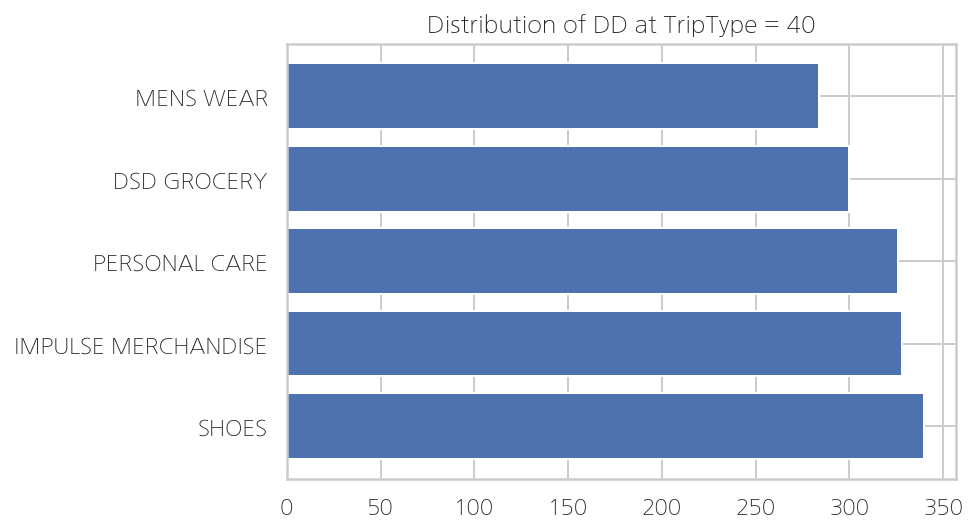

In [141]:
plt.barh((train_40_groupby['DepartmentDescription']
          [:5]), (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 40')

Text(0.5, 1.0, 'Distribution of DD at TripType = 42')

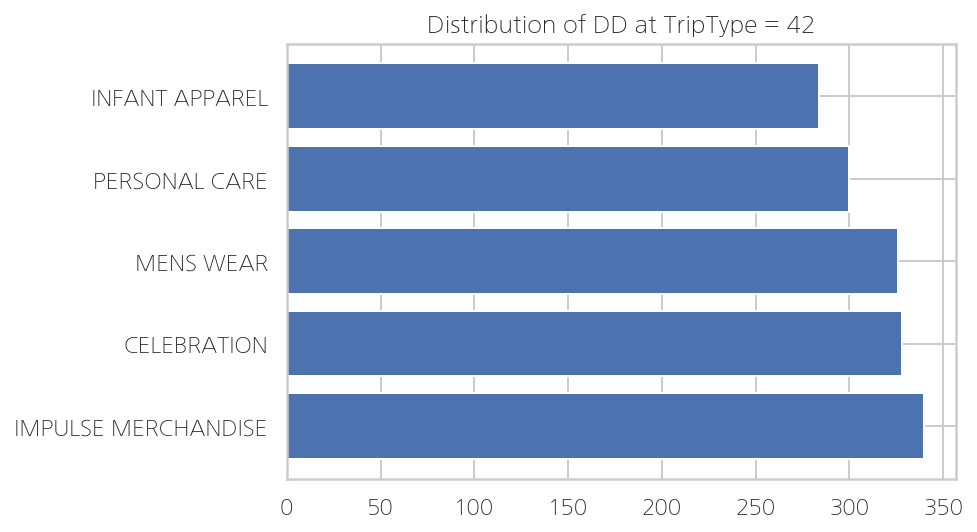

In [142]:
plt.barh((train_42_groupby['DepartmentDescription']
          [:5]), (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 42')

Text(0.5, 1.0, 'Distribution of DD at TripType = 43')

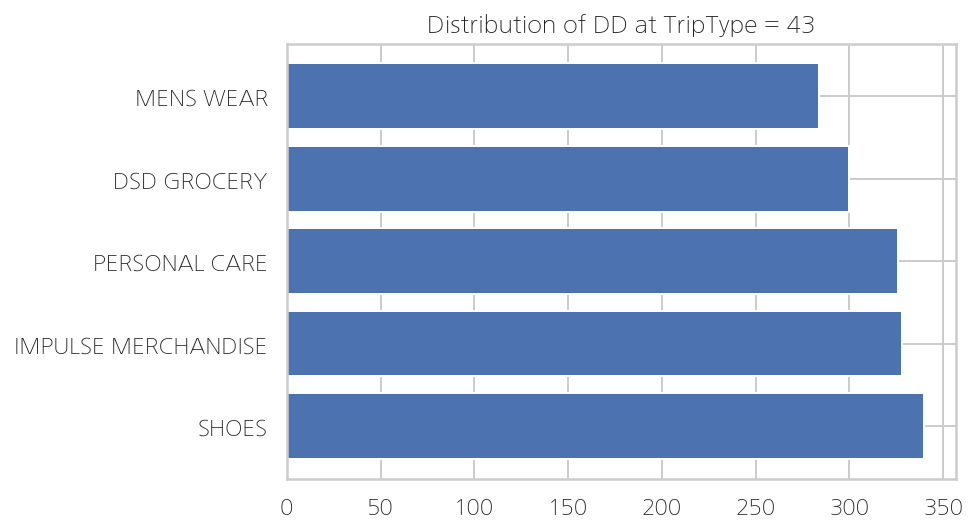

In [143]:
plt.barh((train_43_groupby['DepartmentDescription']
          [:5]), (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 43')

Text(0.5, 1.0, 'Distribution of DD at TripType = 44')

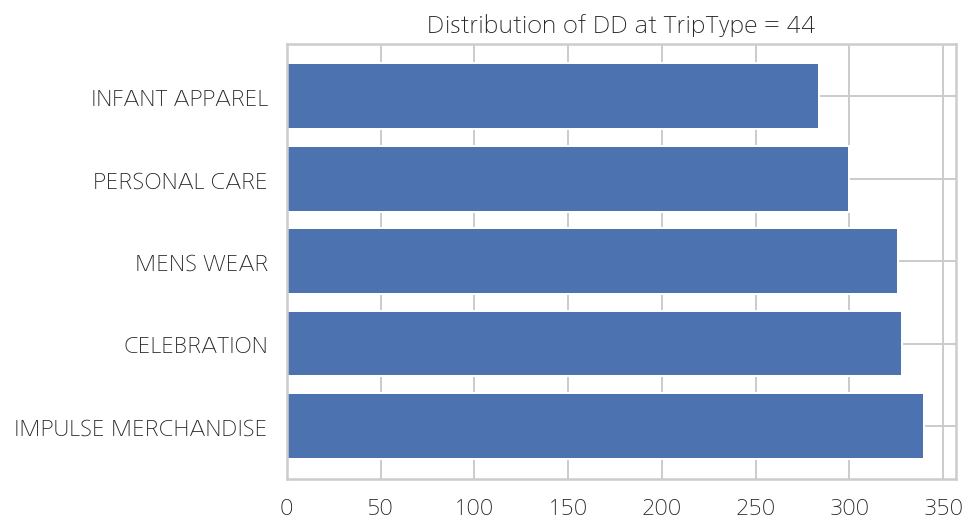

In [144]:
plt.barh((train_44_groupby['DepartmentDescription']
          [:5]), (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 44')